# 24/09/26 - Estudos de redes com de 4 camadas e de 8 a 32 neurônios e validação no treino



## Resumo

- Função de perda: RMSE
- Parânmetros do modelo: k--0.1__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0
- Funções de  ativação: 
    - Elu 
    - Tanh
    - ReLU
    - SiLU

- Tamanhos de batelada e épocas:
    - (10000, 300)

- Arquivo de checkpoint: 1721243952

- Peso da perda de cond. inicial: 10

- Peso da perda de dados: 10

- Condição inicial: 0.5

- Variação da condição inicial: 0.2 (0.4-0.6)

- Parcela de validação: 10%


## Análise de erro vs speedup

In [1]:
import glob
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tools import generate_model, train_data

In [2]:
result_list = glob.glob("pinn_sim/*")

print("numero de arquiteturas testadas: {}".format(len(result_list)))

numero de arquiteturas testadas: 163


In [3]:
results_dict = {}

error_list = []

speed_list = []

for file in result_list:
    i = len(error_list)
    if file.split(".")[-1] == "pkl":
        with open(file, "rb") as f:
            aux_dict = pk.load(f)

        results_dict[i] = {
            "rmse": aux_dict["rmse"],
            "max_ae": aux_dict["max_ae"],
            "mean_speed_up": aux_dict["mean_speed_up"],
            "std_speed_up": aux_dict["std_speed_up"],
            "arch_name": file.split("/")[-1].split(".")[0],
            "file": file,
        }

        results_dict[i]["arch_name"] = file.split("/")[-1].split(".")[0]

        error_list.append(results_dict[i]["rmse"] + results_dict[i]["max_ae"])
        speed_list.append(
            results_dict[i]["mean_speed_up"] - results_dict[i]["std_speed_up"]
        )

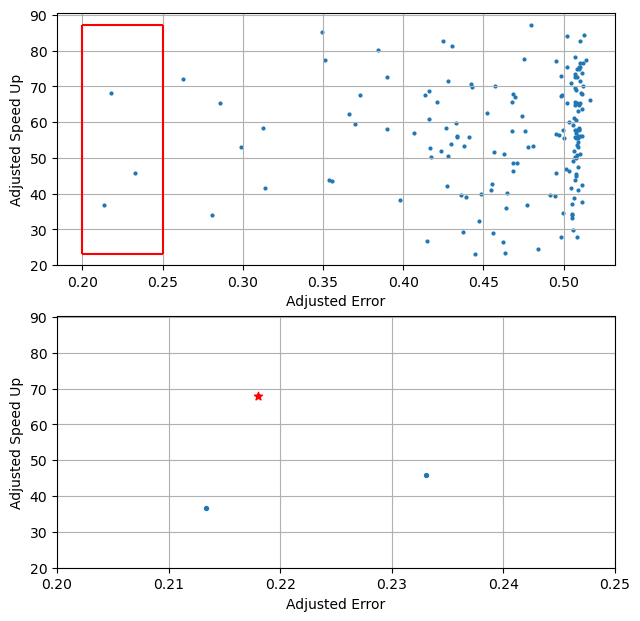

Arquitetura escolhida: epochs_1090__batch_800__arch_Elu--8__Elu--8__Elu--16__ReLU--32__
Erro absoluto médio 0.021694435
Erro absoluto máximo 0.1962766
Speed Up: 86.0057408272082 +/-17.973519147461413


In [5]:
x_lim = (0.2, 0.25)

fig = plt.figure(figsize=[12 * 0.6, 12 * 0.6])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

ax = fig.add_subplot(2, 1, 1)

ax.scatter(error_list, speed_list, s=4)
ax.hlines(max(speed_list), x_lim[0], x_lim[1], color="r")
ax.hlines(min(speed_list), x_lim[0], x_lim[1], color="r")
ax.vlines(x_lim[1], min(speed_list), max(speed_list), color="r")
ax.vlines(x_lim[0], min(speed_list), max(speed_list), color="r")

choice = np.intersect1d(
    np.argwhere(np.array(speed_list) > 60), np.argwhere(np.array(error_list) < 0.25)
)[0]

ax.set_xlabel("Adjusted Error")
ax.set_ylabel("Adjusted Speed Up")

ax.grid()

ax = fig.add_subplot(2, 1, 2)

ax.scatter(error_list, speed_list, s=8)
ax.scatter(error_list[choice], speed_list[choice], c="r", marker="*")
ax.set_xlim(x_lim[0], x_lim[1])

ax.set_xlabel("Adjusted Error")
ax.set_ylabel("Adjusted Speed Up")

ax.grid()

plt.show()

arch_str = results_dict[choice]["arch_name"]

print("Arquitetura escolhida: " + arch_str)
print("Erro absoluto médio", results_dict[choice]["rmse"])
print("Erro absoluto máximo", results_dict[choice]["max_ae"])
print(
    "Speed Up: {} +/-{}".format(
        results_dict[choice]["mean_speed_up"], results_dict[choice]["std_speed_up"]
    )
)

In [7]:
with open("learning_curves/C_pde_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_pde_loss_it = pk.load(f)

with open("learning_curves/C_data_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_data_loss_it = pk.load(f)

# with open("learning_curves/C_boundary_loss_it__" + arch_str + ".pkl", "rb") as f:
#     C_boundary_loss_it = pk.load(f)

with open("learning_curves/C_initial_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_initial_loss_it = pk.load(f)

with open("learning_curves/val_loss_it__" + arch_str + ".pkl", "rb") as f:
    val_loss_it = pk.load(f)

results_dict[choice]

with open(results_dict[choice]["file"], "rb") as f:
    aux_dict = pk.load(f)
    Cl_pinn_lin = aux_dict["Cl_pinn"].numpy()
    Cp_pinn_lin = aux_dict["Cp_pinn"].numpy()

size_t = int(len(Cl_pinn_lin) ** 0.5)

struct_name = "h--0.1__k--0.1__Db--0.0001__Dn--0.0001__phi--0.2__ksi--0.0__cb--0.15__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__Cn_max--0.5__X_nb--0.0001__x_dom_min--0__x_dom_max--1__y_dom_min--0__y_dom_max--1__t_dom_min--0__t_dom_max--10"


with open("fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cp = pk.load(f)

with open("fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cl = pk.load(f)


x_dom = (0, 1)
y_dom = (0, 1)
t_dom = (0, 10)
h = 0.1
k = 0.1

size_x = int(((x_dom[1] - x_dom[0]) / (h))) + 1
size_y = int(((y_dom[1] - y_dom[0]) / (h))) + 1
size_t = int(((t_dom[1] - t_dom[0]) / (k))) + 1

Cp_pinn_np = Cp_pinn_lin.reshape(size_t, size_x, size_y)
Cl_pinn_np = Cl_pinn_lin.reshape(size_t, size_x, size_y)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)


X, Y = np.meshgrid(
    x_np,
    y_np,
)

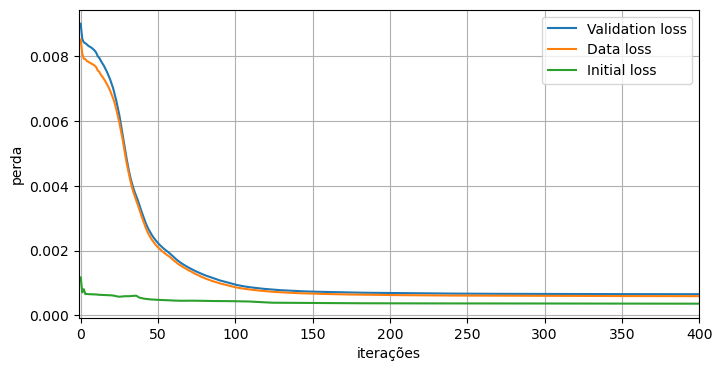

In [8]:
scale_factor = 0.5
fig = plt.figure(figsize=[16 * scale_factor, 8 * scale_factor])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
# ax.plot(
#     range(len(C_boundary_loss_it)),
#     C_boundary_loss_it,
#     label="Boundary loss",
# )

ax.plot(
    range(len(val_loss_it)),
    val_loss_it,
    label="Validation loss",
)

ax.plot(
    range(len(C_data_loss_it)),
    C_data_loss_it,
    label="Data loss",
)

ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it,
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()
ax.set_xlim(-1,400)

plt.show()

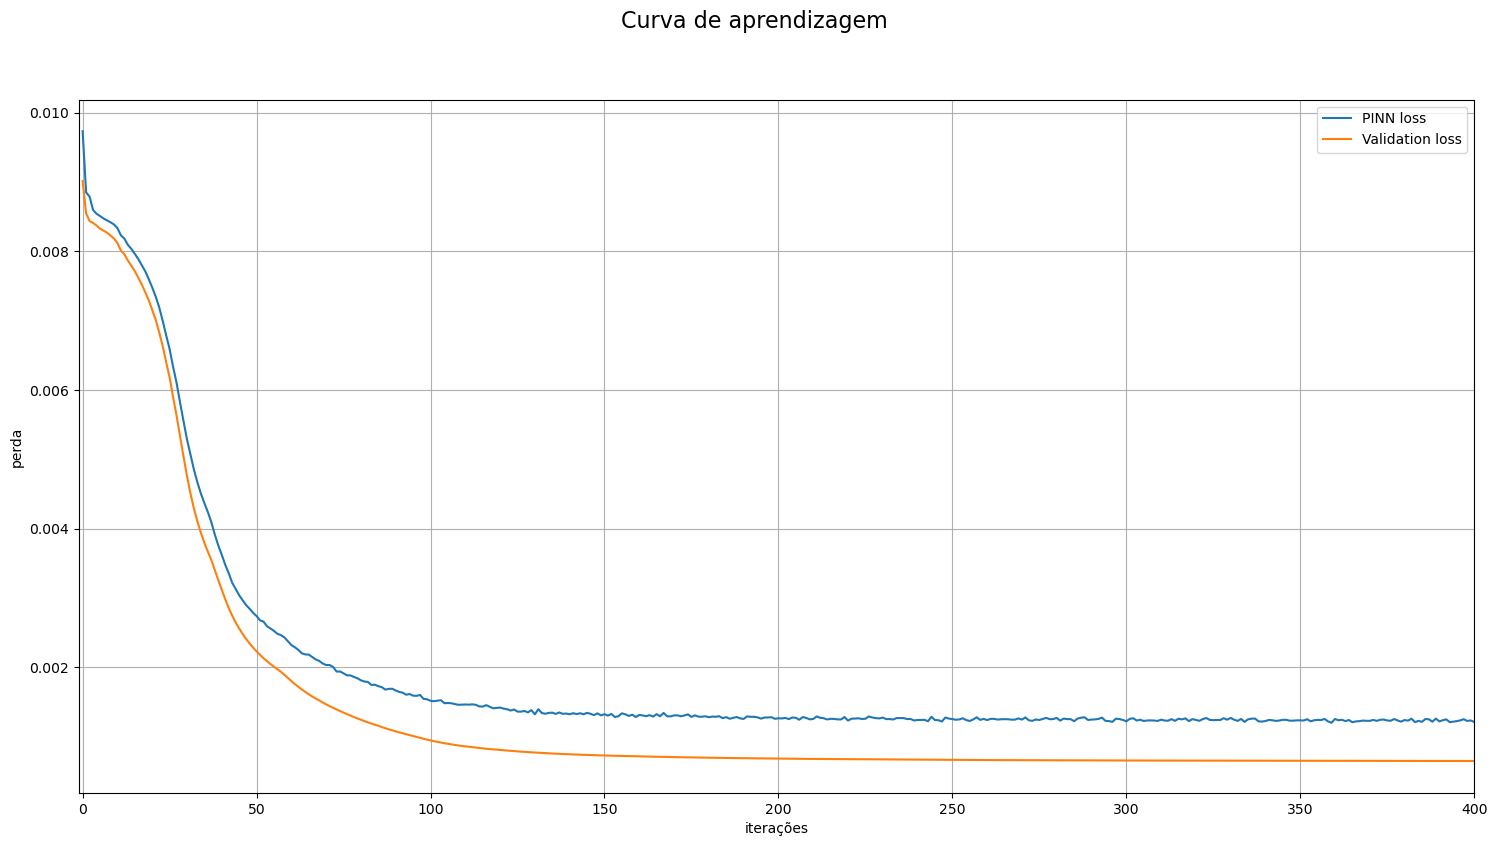

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it + C_pde_loss_it + C_data_loss_it,
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it)),
    val_loss_it,
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()
ax.set_xlim(-1, 400)

plt.show()

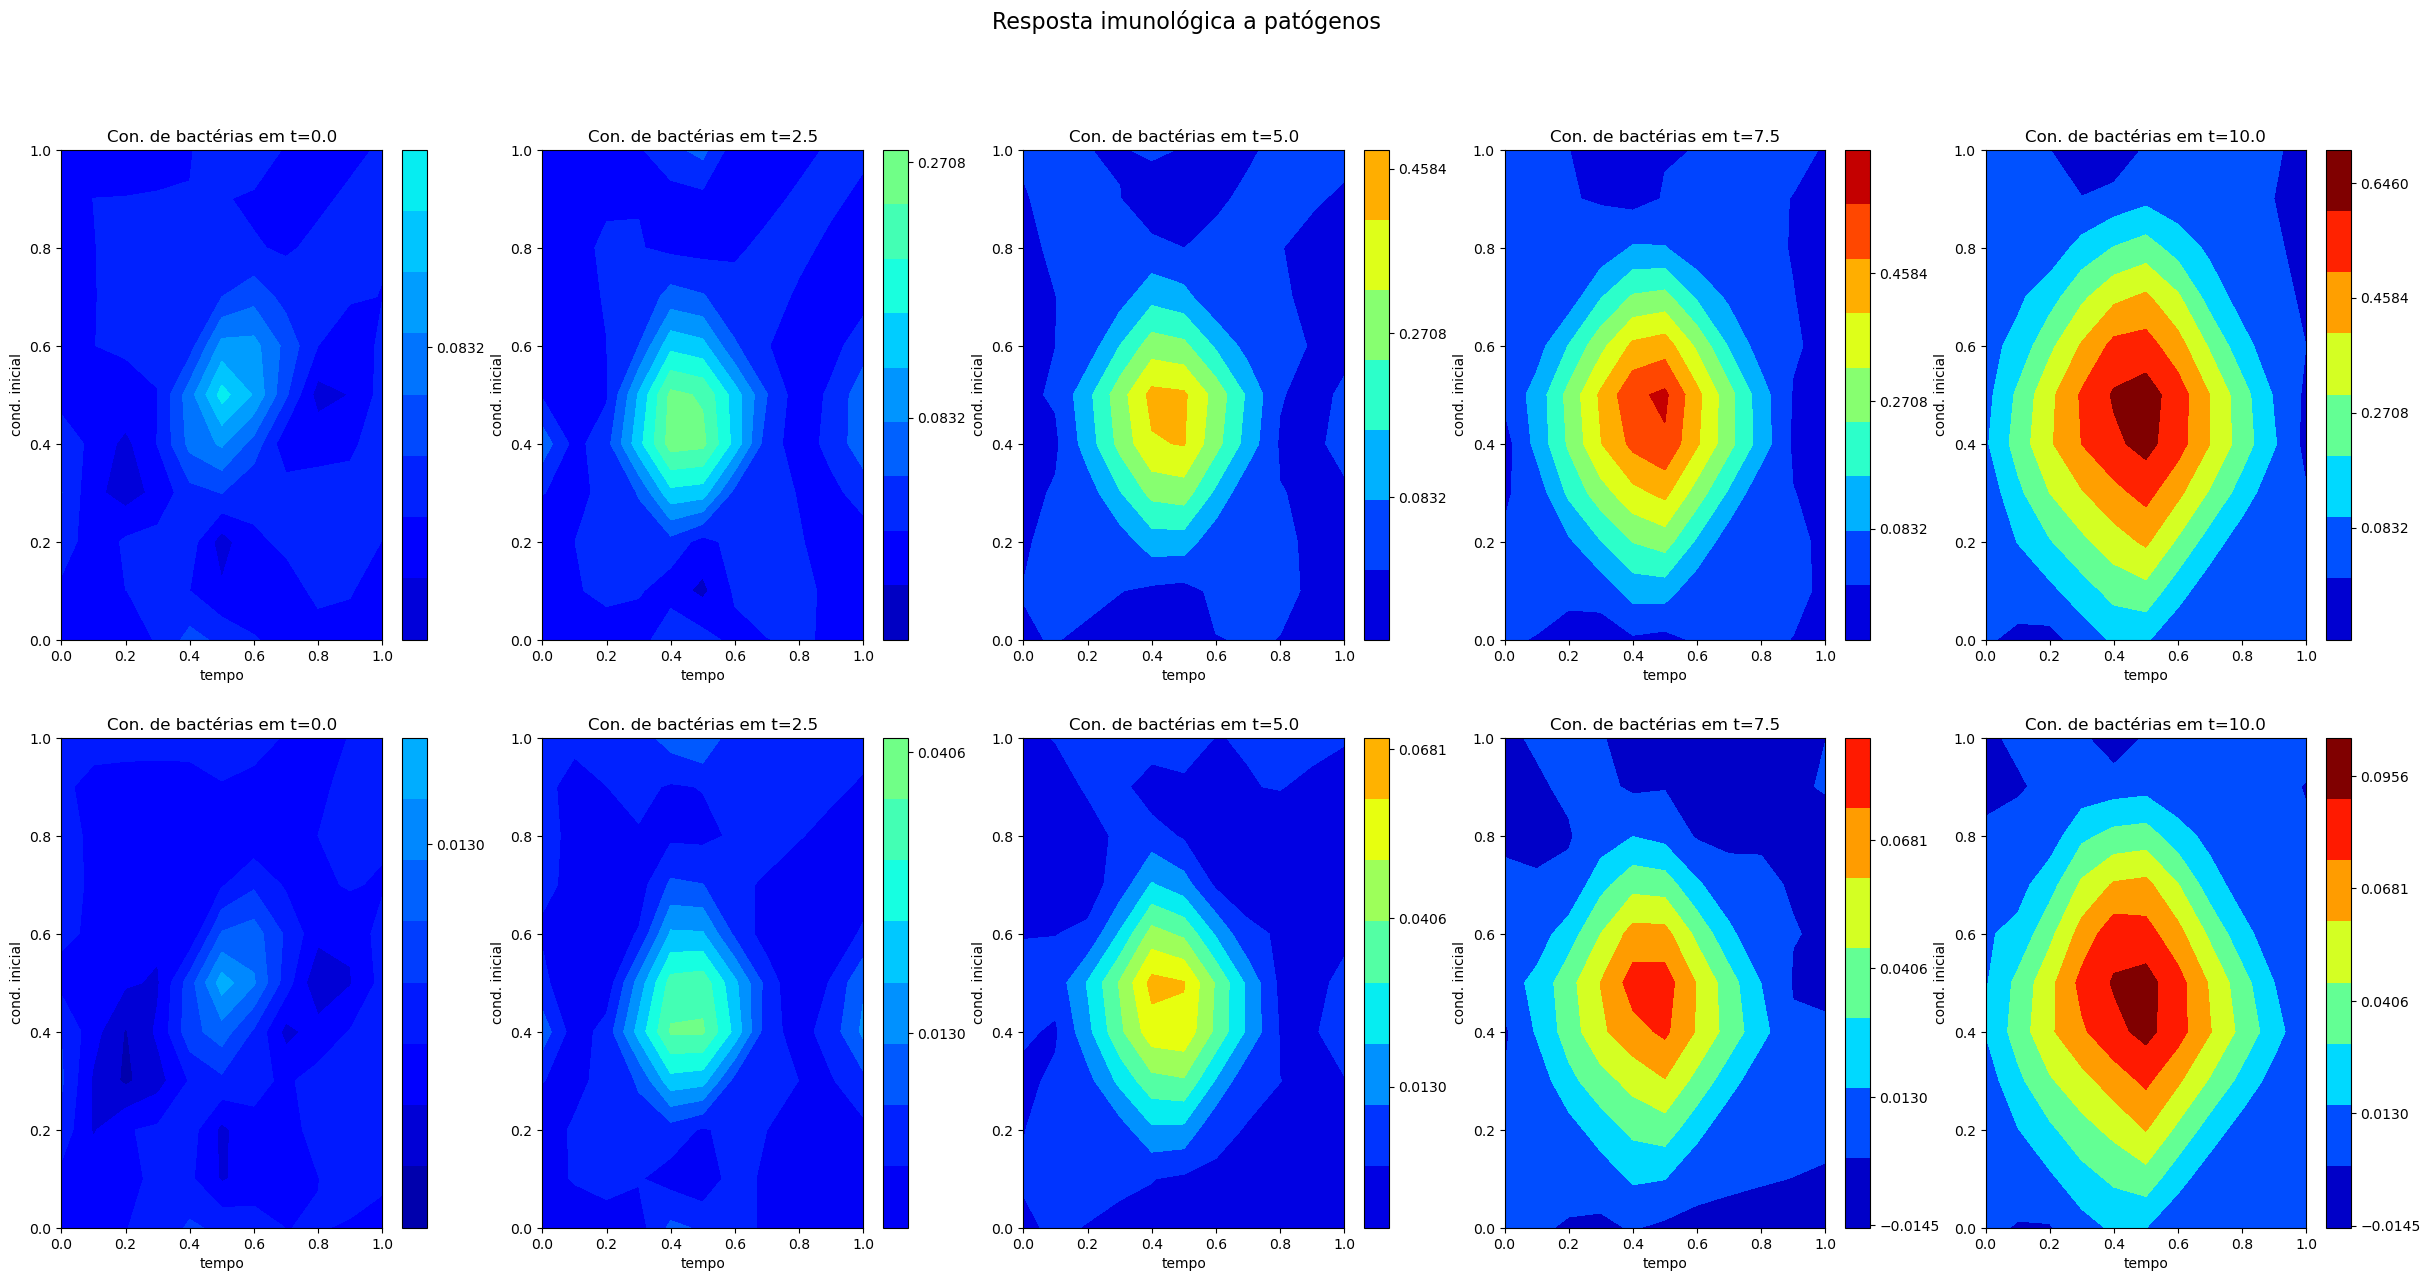

In [11]:

time_plot = np.linspace(0, len(t_np) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t_np[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("Con. de bactérias em t={}".format(t_np[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

## Comparação com NN

In [17]:
data_input_np = np.array([Cl.flatten(), Cp.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = (
        torch.tensor(tt, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    initial_tc = (
        torch.tensor(ii, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32).to(device)

else:
    device = torch.device("cpu")
    t = torch.tensor(tt, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    initial_tc = torch.tensor(ll, dtype=torch.float32, requires_grad=True).reshape(
        -1, 1
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32)

n_epochs = int(arch_str.split("__")[0].split("_")[-1])
batch_size = int(arch_str.split("__")[1].split("_")[-1])
model = generate_model(arch_str.split("arch_")[-1]).to(device)

model, nn_loss, nn_val_loss = train_data(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=0.999,
    model=model,
    initial=initial_tc,
    device=device,
    data_input=data_input,
    t=t,
    validation=0.1,
    norm_weights=None,
)

mesh = torch.cat([t, initial_tc], dim=1)
with torch.no_grad():
    Cl_nn_data, Cp_nn_data = model(mesh).cpu().split(1, dim=1)


Cl_nn_data = Cl_nn_data.detach().numpy().reshape(size_t + 1, size_t + 1)
Cp_nn_data = Cp_nn_data.detach().numpy().reshape(size_t + 1, size_t + 1)

NameError: name 'tt' is not defined

In [7]:
rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_nn_data, Cp_nn_data, Cl.flatten(), Cp.flatten()
        )
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_nn_data, Cp_nn_data, Cl.flatten(), Cp.flatten()
        )
    ]
)

print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)

Erro absoluto médio 0.09456441236411893
Erro absoluto máximo 0.11761788129806516


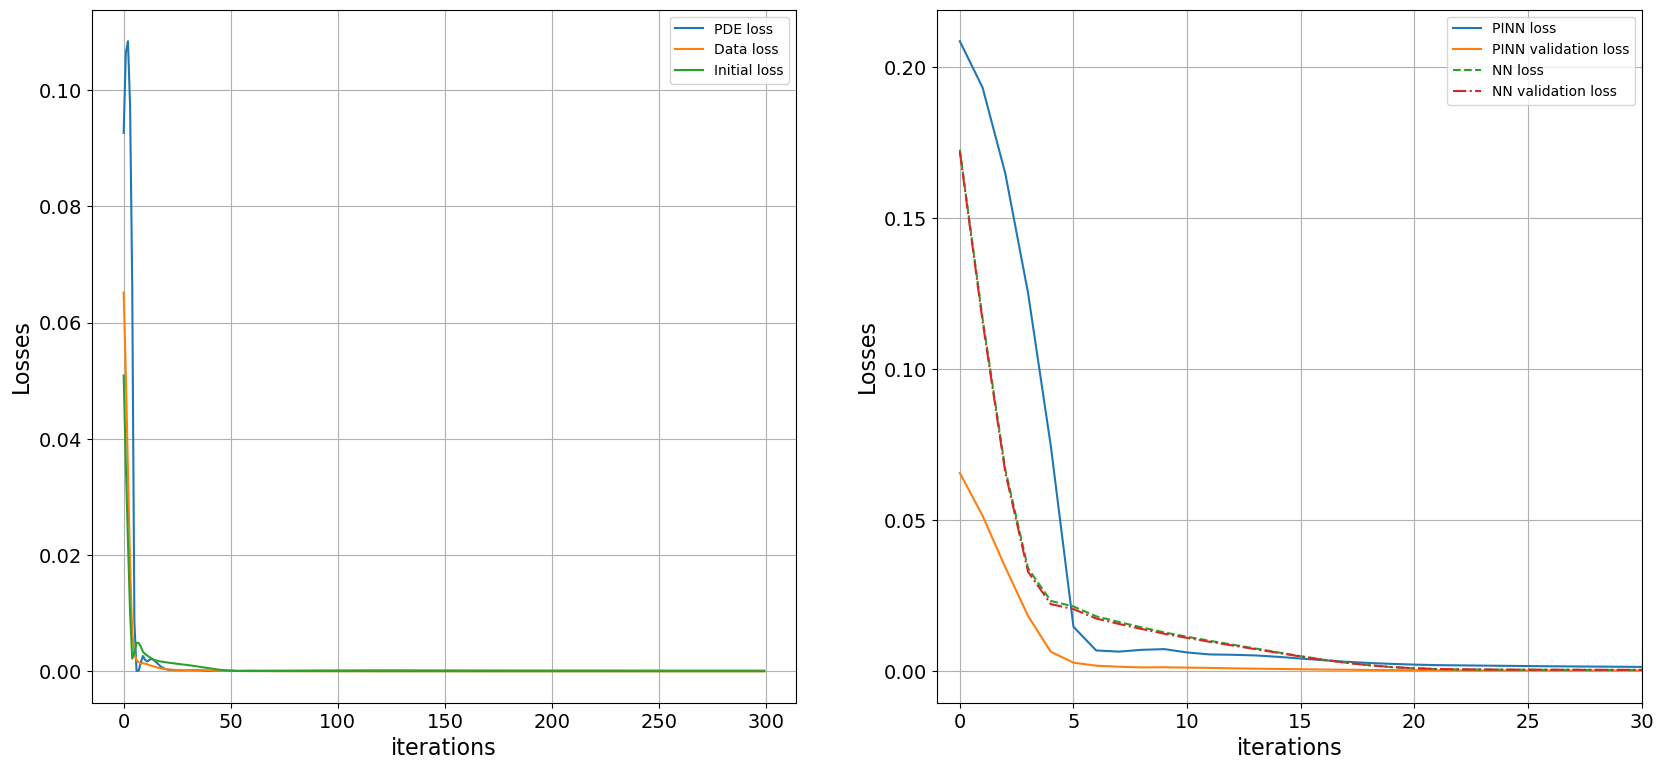

In [8]:
scale_factor = 1

fig = plt.figure(figsize=[20 * scale_factor, 9 * scale_factor])

# fig.suptitle("Curva de aprendizagem", fontsize=16)

ax = fig.add_subplot(1, 2, 1)

ax.set_xlabel("iterations", fontsize=16)
ax.set_ylabel("Losses", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.plot(
    range(len(C_pde_loss_it)),
    C_pde_loss_it,
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it)),
    C_data_loss_it,
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it,
    label="Initial loss",
)

# ax.set_yscale("log")
ax.grid()
ax.legend()

ax = fig.add_subplot(1, 2, 2)

ax.set_xlabel("iterations", fontsize=16)
ax.set_ylabel("Losses", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it + C_pde_loss_it + C_data_loss_it,
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it)),
    val_loss_it,
    label="PINN validation loss",
)

ax.plot(
    range(len(C_initial_loss_it)),
    nn_loss.cpu().detach().numpy(),
    "--",
    label="NN loss",
)
ax.plot(
    range(len(val_loss_it)),
    nn_val_loss.cpu().detach().numpy(),
    "-.",
    label="NN validation loss",
)
#
# ax.set_yscale("log")
ax.grid()
ax.legend()
ax.set_xlim(-1, 30)

plt.show()

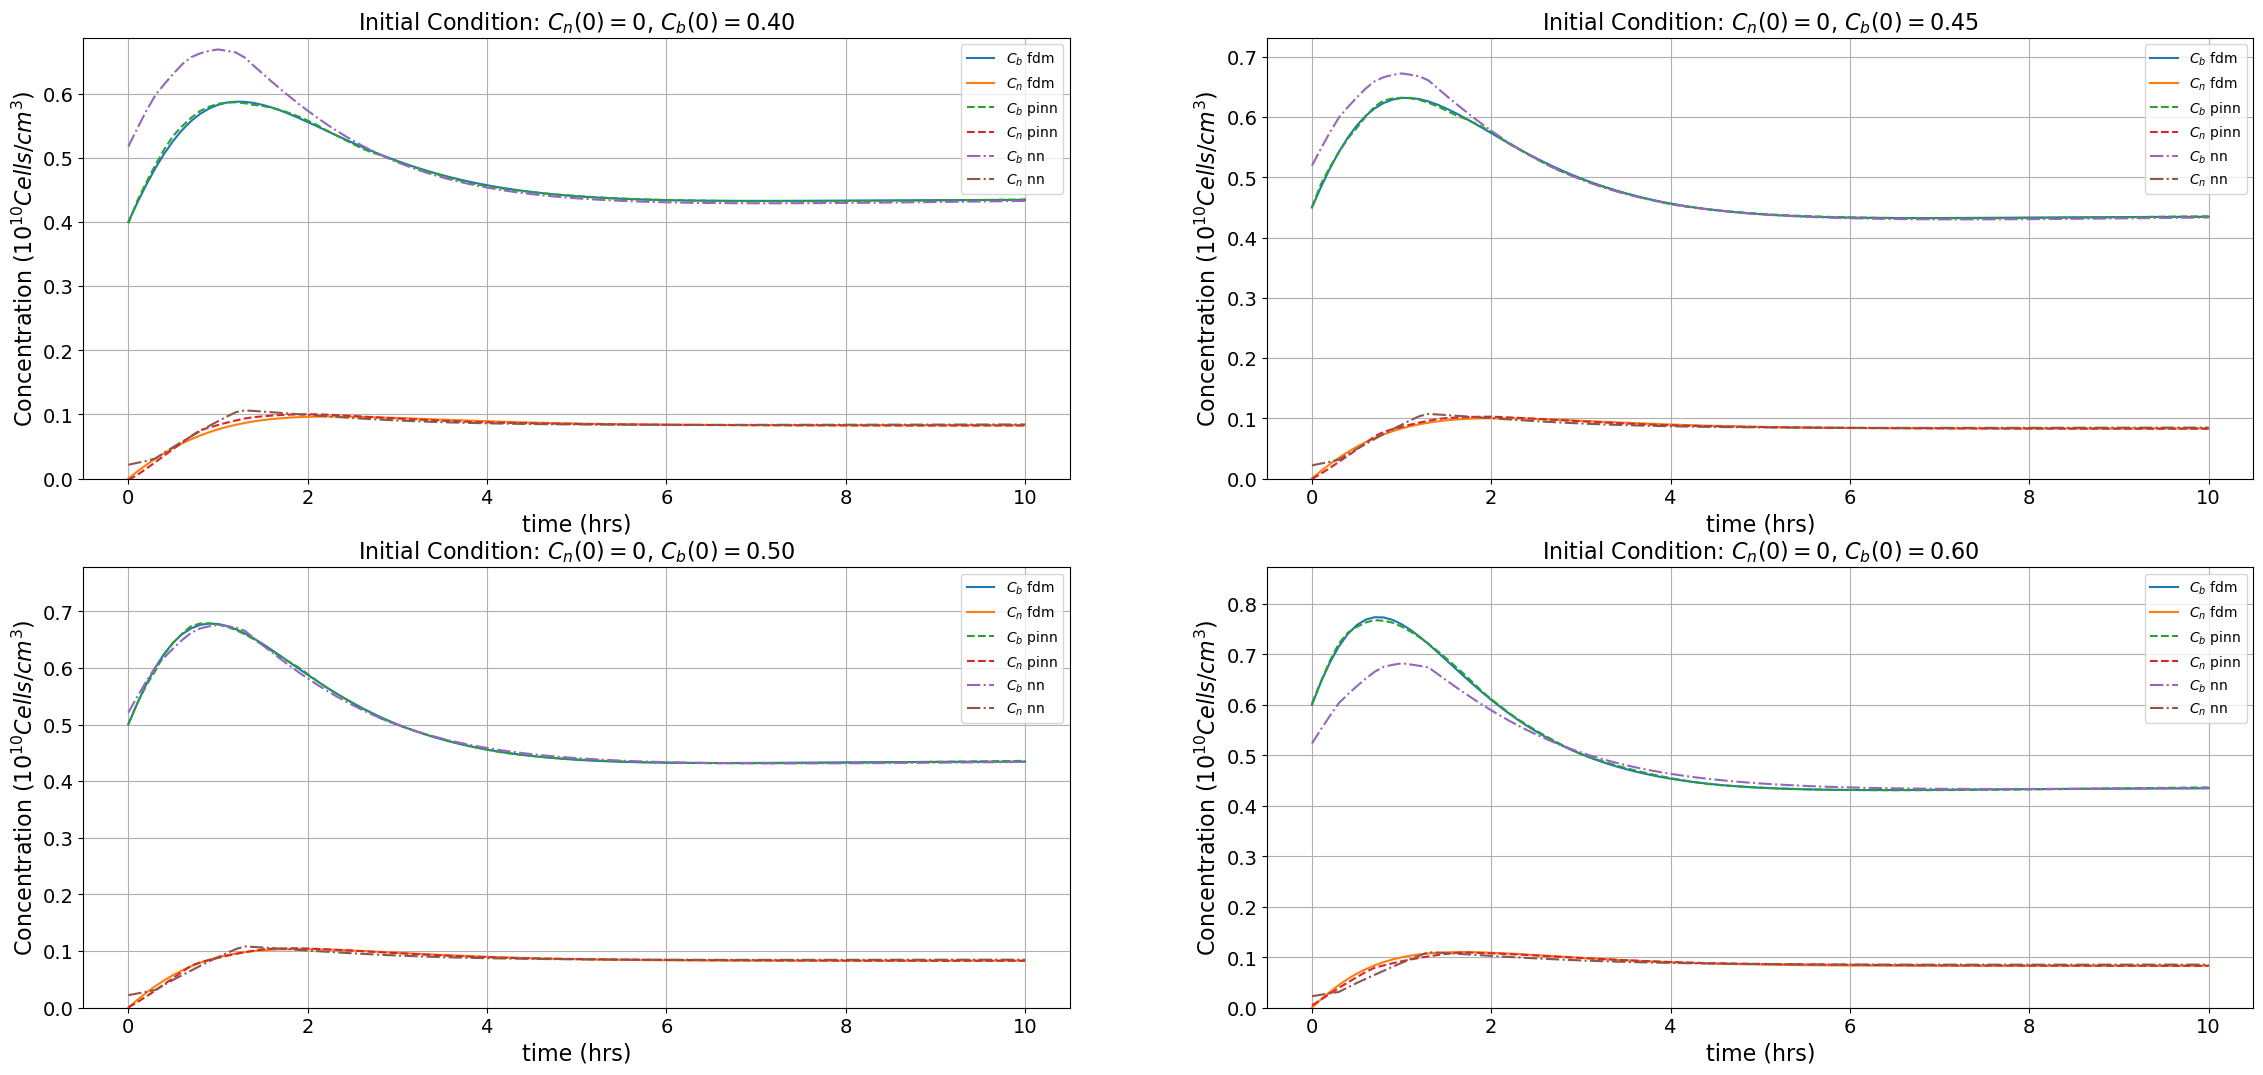

In [9]:
scale_factor = 1.4

fig = plt.figure(figsize=[20 * scale_factor, 9 * scale_factor])

# fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

cp_real_1 = Cp[0, :]
cl_real_1 = Cl[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
cp_nn_1 = Cp_nn_data[0, :]
cl_nn_1 = Cl_nn_data[0, :]
ini_1 = initial[0]

cp_real_2 = Cp[25, :]
cl_real_2 = Cl[25, :]
cp_pinn_2 = Cp_pinn_np[25, :]
cl_pinn_2 = Cl_pinn_np[25, :]
cp_nn_2 = Cp_nn_data[25, :]
cl_nn_2 = Cl_nn_data[25, :]
ini_2 = initial[25]

cp_real_3 = Cp[50, :]
cl_real_3 = Cl[50, :]
cp_pinn_3 = Cp_pinn_np[50, :]
cl_pinn_3 = Cl_pinn_np[50, :]
cp_nn_3 = Cp_nn_data[50, :]
cl_nn_3 = Cl_nn_data[50, :]
ini_3 = initial[50]


cp_real_4 = Cp[100, :]
cl_real_4 = Cl[100, :]
cp_pinn_4 = Cp_pinn_np[100, :]
cl_pinn_4 = Cl_pinn_np[100, :]
cp_nn_4 = Cp_nn_data[100, :]
cl_nn_4 = Cl_nn_data[100, :]
ini_4 = initial[100]

# Plotango 3D
ax = fig.add_subplot(2, 2, 1)
ax.set_title(
    "Initial Condition: $C_n(0) = 0$, $C_b(0) = {:.2f}$".format(ini_1), fontsize=16
)

ax.plot(t_np, cp_real_1, label="$C_b$ fdm")
ax.plot(t_np, cl_real_1, label="$C_n$ fdm")
ax.plot(t_np, cp_pinn_1, "--", label="$C_b$ pinn")
ax.plot(t_np, cl_pinn_1, "--", label="$C_n$ pinn")
ax.plot(t_np, cp_nn_1, "-.", label="$C_b$ nn")
ax.plot(t_np, cl_nn_1, "-.", label="$C_n$ nn")

ax.set_xlabel("time (hrs)", fontsize=16)
ax.set_ylabel("Concentration $(10^{10}Cells/cm^3)$", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

vmax = np.max(
    [
        np.max(cp_real_1),
        np.max(cl_real_1),
        np.max(cp_pinn_1),
        np.max(cl_pinn_1),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(2, 2, 2)
ax.set_title(
    "Initial Condition: $C_n(0) = 0$, $C_b(0) = {:.2f}$".format(ini_2), fontsize=16
)

ax.plot(t_np, cp_real_2, label="$C_b$ fdm")
ax.plot(t_np, cl_real_2, label="$C_n$ fdm")
ax.plot(t_np, cp_pinn_2, "--", label="$C_b$ pinn")
ax.plot(t_np, cl_pinn_2, "--", label="$C_n$ pinn")
ax.plot(t_np, cp_nn_2, "-.", label="$C_b$ nn")
ax.plot(t_np, cl_nn_2, "-.", label="$C_n$ nn")
ax.set_xlabel("time (hrs)", fontsize=16)
ax.set_ylabel("Concentration $(10^{10}Cells/cm^3)$", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

vmax = np.max(
    [
        np.max(cp_real_2),
        np.max(cl_real_2),
        np.max(cp_pinn_2),
        np.max(cl_pinn_2),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(2, 2, 3)
ax.set_title(
    "Initial Condition: $C_n(0) = 0$, $C_b(0) = {:.2f}$".format(ini_3), fontsize=16
)

ax.plot(t_np, cp_real_3, label="$C_b$ fdm")
ax.plot(t_np, cl_real_3, label="$C_n$ fdm")
ax.plot(t_np, cp_pinn_3, "--", label="$C_b$ pinn")
ax.plot(t_np, cl_pinn_3, "--", label="$C_n$ pinn")
ax.plot(t_np, cp_nn_3, "-.", label="$C_b$ nn")
ax.plot(t_np, cl_nn_3, "-.", label="$C_n$ nn")
ax.set_xlabel("time (hrs)", fontsize=16)
ax.set_ylabel("Concentration $(10^{10}Cells/cm^3)$", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

vmax = np.max(
    [
        np.max(cp_real_3),
        np.max(cl_real_3),
        np.max(cp_pinn_3),
        np.max(cl_pinn_3),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(2, 2, 4)
ax.set_title(
    "Initial Condition: $C_n(0) = 0$, $C_b(0) = {:.2f}$".format(ini_4), fontsize=16
)

ax.plot(t_np, cp_real_4, label="$C_b$ fdm")
ax.plot(t_np, cl_real_4, label="$C_n$ fdm")
ax.plot(t_np, cp_pinn_4, "--", label="$C_b$ pinn")
ax.plot(t_np, cl_pinn_4, "--", label="$C_n$ pinn")
ax.plot(t_np, cp_nn_4, "-.", label="$C_b$ nn")
ax.plot(t_np, cl_nn_4, "-.", label="$C_n$ nn")
ax.set_xlabel("time (hrs)", fontsize=16)
ax.set_ylabel("Concentration $(10^{10}Cells/cm^3)$", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

vmax = np.max(
    [
        np.max(cp_real_4),
        np.max(cl_real_4),
        np.max(cp_pinn_4),
        np.max(cl_pinn_4),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()

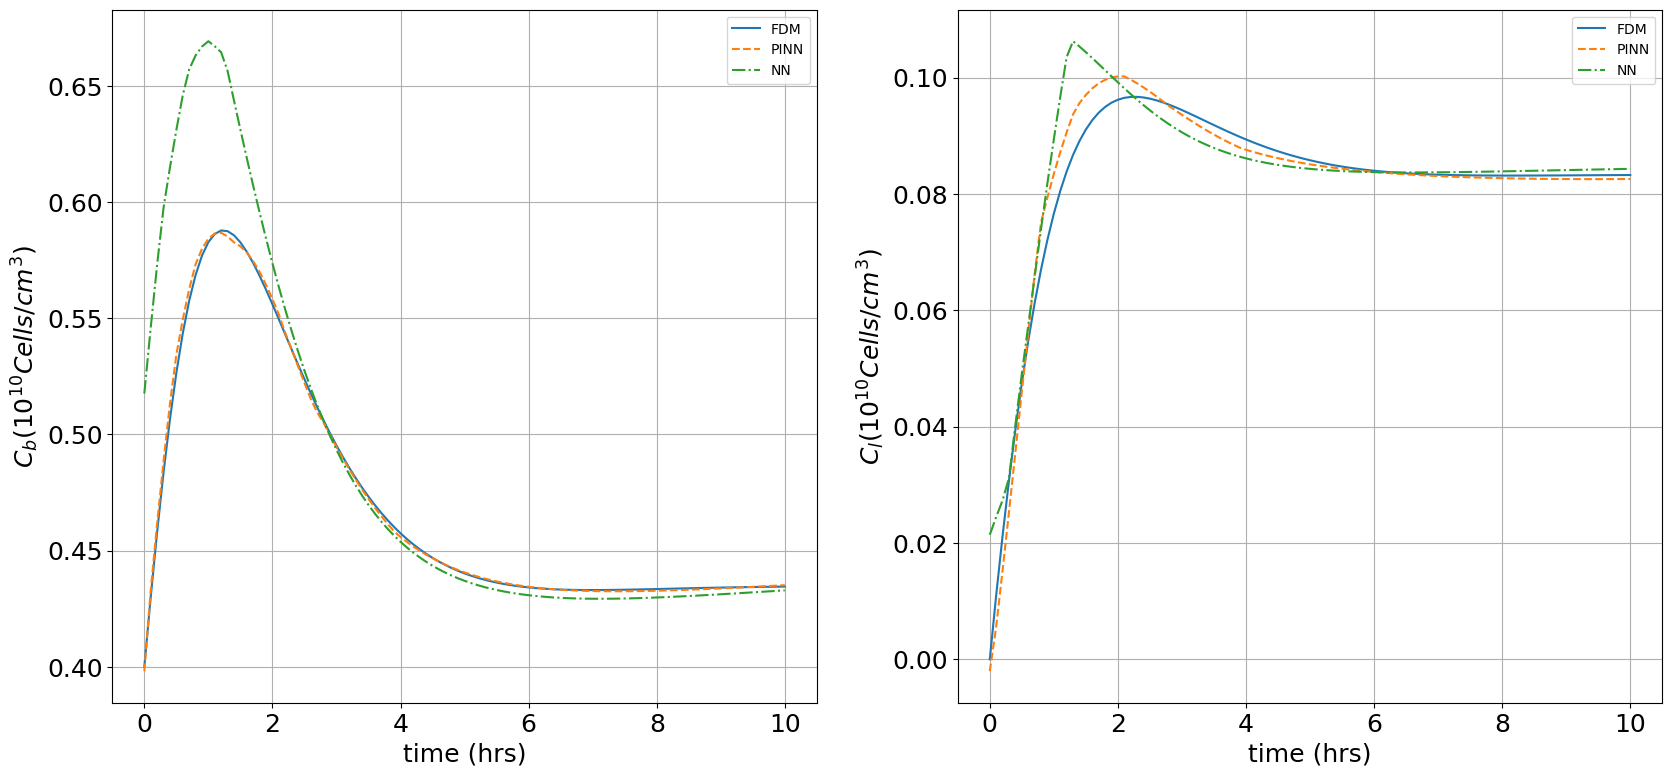

In [23]:
scale_factor = 1

fig = plt.figure(figsize=[20 * scale_factor, 9 * scale_factor])

# fig.suptitle("Concentração de patógenos e leucócitos", fontsize=18)


vmin = 0

cp_real_1 = Cp[0, :]
cl_real_1 = Cl[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
cp_nn_1 = Cp_nn_data[0, :]
cl_nn_1 = Cl_nn_data[0, :]
ini_1 = initial[0]

# Plotango 3D
ax = fig.add_subplot(1, 2, 1)
# ax.set_title("$C_b$ for $C_b(0) = {:.2f}$".format(ini_1), fontsize=18)

ax.plot(t_np, cp_real_1, label="FDM")
ax.plot(t_np, cp_pinn_1, "--", label="PINN")
ax.plot(t_np, cp_nn_1, "-.", label="NN")

ax.set_xlabel("time (hrs)", fontsize=18)
ax.set_ylabel("$C_b(10^{10}Cells/cm^3)$", fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


ax.legend()
ax.grid()

ax = fig.add_subplot(1, 2, 2)
# ax.set_title("$C_n$ for $C_b(0) = {:.2f}$".format(ini_1), fontsize=18)


ax.plot(t_np, cl_real_1, label="FDM")
ax.plot(t_np, cl_pinn_1, "--", label="PINN")
ax.plot(t_np, cl_nn_1, "-.", label="NN")


ax.set_xlabel("time (hrs)", fontsize=18)
ax.set_ylabel("$C_l(10^{10}Cells/cm^3)$", fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.legend()
ax.grid()


plt.show()

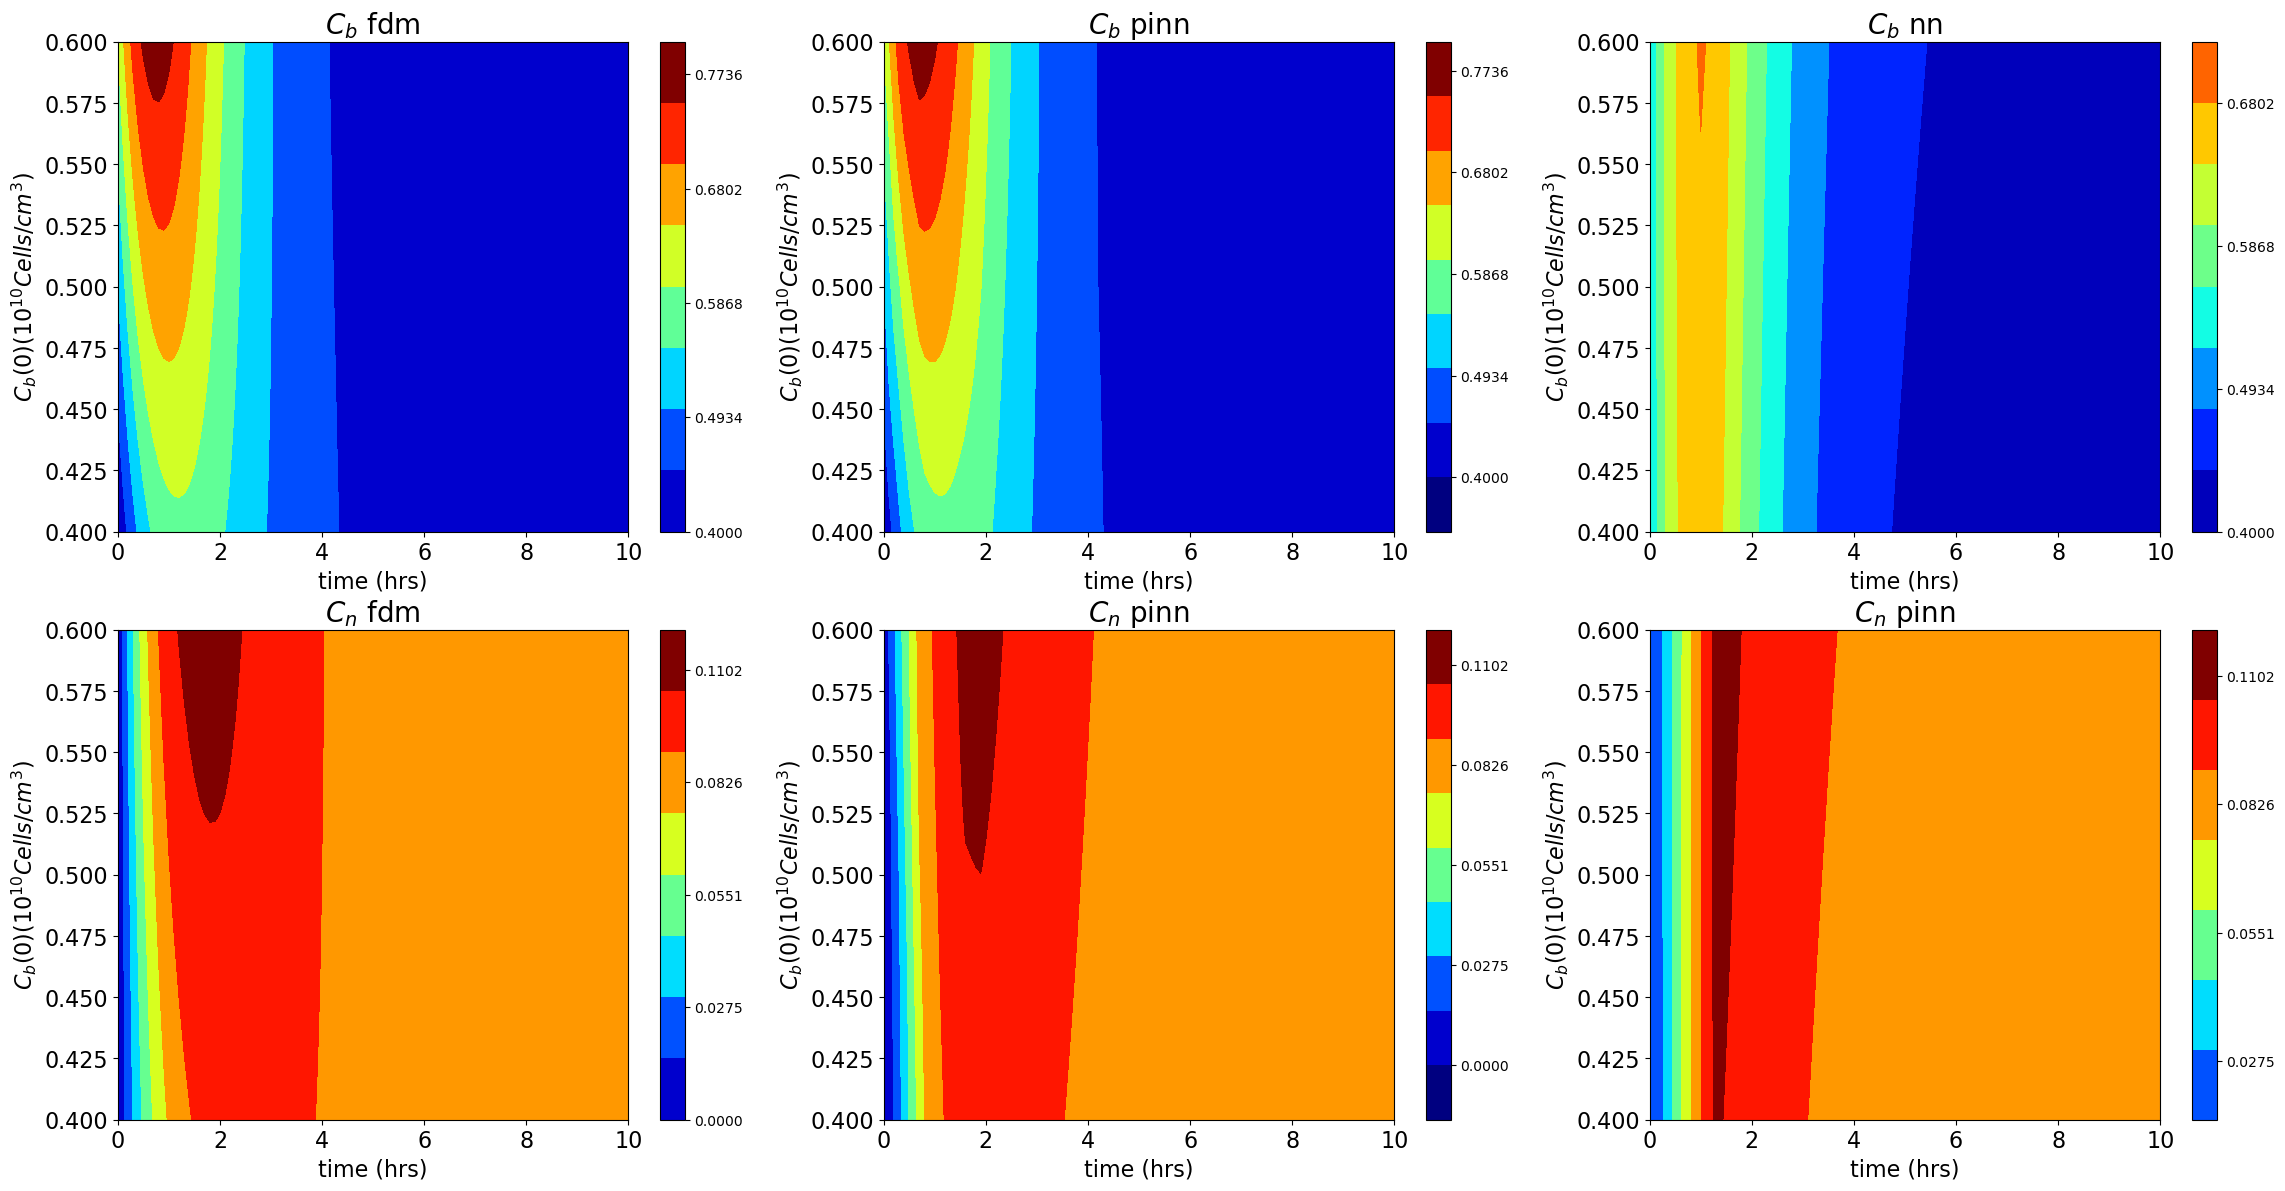

In [27]:
scale_factor = 1.4
fig = plt.figure(figsize=[20 * scale_factor, 10 * scale_factor])

# fig.suptitle("Imune system response", fontsize=20)


ax = fig.add_subplot(2, 3, 1)

vmin = np.min(Cp)
vmax = np.max(Cp)

contour = ax.contourf(
    tt,
    ii,
    Cp.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("$C_b$ fdm", fontsize=20)
ax.set_xlabel("time (hrs)", fontsize=16)
ax.set_ylabel("$C_b(0) (10^{10}Cells/cm^3)$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

ax = fig.add_subplot(2, 3, 2)

# vmin = np.min(Cp_pinn_np)
# vmax = np.max(Cp_pinn_np)

contour = ax.contourf(
    tt,
    ii,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("$C_b$ pinn", fontsize=20)
ax.set_xlabel("time (hrs)", fontsize=16)
ax.set_ylabel("$C_b(0) (10^{10}Cells/cm^3)$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

ax = fig.add_subplot(2, 3, 3)

# vmin = np.min(Cp_nn_data)
# vmax = np.max(Cp_nn_data)

contour = ax.contourf(
    tt,
    ii,
    Cp_nn_data,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("$C_b$ nn", fontsize=20)
ax.set_xlabel("time (hrs)", fontsize=16)
ax.set_ylabel("$C_b(0) (10^{10}Cells/cm^3)$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

ax = fig.add_subplot(2, 3, 4)

vmin = np.min(Cl)
vmax = np.max(Cl)

contour = ax.contourf(
    tt,
    ii,
    Cl.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("$C_n$ fdm", fontsize=20)
ax.set_xlabel("time (hrs)", fontsize=16)
ax.set_ylabel("$C_b(0) (10^{10}Cells/cm^3)$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

ax = fig.add_subplot(2, 3, 5)

# vmin = np.min(Cl_pinn_np)
# vmax = np.max(Cl_pinn_np)

contour = ax.contourf(
    tt,
    ii,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("$C_n$ pinn", fontsize=20)
ax.set_xlabel("time (hrs)", fontsize=16)
ax.set_ylabel("$C_b(0) (10^{10}Cells/cm^3)$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

ax = fig.add_subplot(2, 3, 6)

# vmin = np.min(Cl_nn_data)
# vmax = np.max(Cl_nn_data)

contour = ax.contourf(
    tt,
    ii,
    Cl_nn_data,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("$C_n$ pinn", fontsize=20)
ax.set_xlabel("time (hrs)", fontsize=16)
ax.set_ylabel("$C_b(0) (10^{10}Cells/cm^3)$", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()